# Importing Libararies

In [1]:
import os
import numpy as np # linear algebra
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,confusion_matrix
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator, array_to_img
from matplotlib.pyplot import imshow
from tensorflow.keras.callbacks import ReduceLROnPlateau
import shutil
from PIL import Image

# Looking into structure of file arrangements

In [2]:
for dirnames, _, filenames in os.walk('c'):
    print(dirnames)
    if len(filenames) > 0:
        print(f'Contains {len(filenames)} number of files')
        #print(filenames)

In [3]:
DIR = '/kaggle/input/mango-leaf-disease-dataset/'

In [4]:
files = os.listdir(DIR)
print(files)
class_count = len(files)
print(f'There are {class_count} car model classes.')

['Powdery Mildew', 'Cutting Weevil', 'Anthracnose', 'Bacterial Canker', 'Sooty Mould', 'Gall Midge', 'Healthy', 'Die Back']
There are 8 car model classes.


In [5]:
# Remove Non JPG images
for cls in files:
    cls_path = os.path.join(DIR, cls)
    imgs =  os.listdir(cls_path)
    img = Image.open(os.path.join(cls_path,imgs[0]))
    print(f'Class {cls} contains {len(os.listdir(cls_path))} images of shape {img.size}.')

Class Powdery Mildew contains 500 images of shape (320, 240).
Class Cutting Weevil contains 500 images of shape (240, 240).
Class Anthracnose contains 500 images of shape (320, 240).
Class Bacterial Canker contains 500 images of shape (320, 240).
Class Sooty Mould contains 500 images of shape (240, 320).
Class Gall Midge contains 500 images of shape (320, 240).
Class Healthy contains 500 images of shape (320, 240).
Class Die Back contains 500 images of shape (240, 240).


(240, 320, 3)


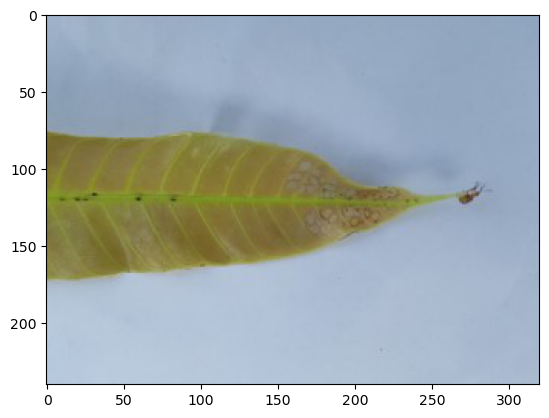

In [6]:
fpath=r'/kaggle/input/mango-leaf-disease-dataset/Anthracnose/20211008_124249 (Custom).jpg'
img=plt.imread(fpath)
print (img.shape)
imshow(img)

# Loading the dataset

In [7]:
filepaths=[]
labels=[]
classlist=os.listdir(DIR)
classlist.sort()
for klass in classlist:
    classpath=os.path.join(DIR, klass)
    flist=os.listdir(classpath)
    for f in flist:
        fpath=os.path.join(classpath,f)        
        filepaths.append(fpath)
        labels.append(klass)
    Fseries= pd.Series(filepaths, name='filepaths')
    Lseries=pd.Series(labels, name='labels') 
    data_df=pd.concat([Fseries, Lseries], axis=1)
data_df = data_df.sample(frac=1)

# Data Visualization and Preprocessing

<AxesSubplot:title={'center':'Total Label Count Visualization'}, xlabel='labels', ylabel='count'>

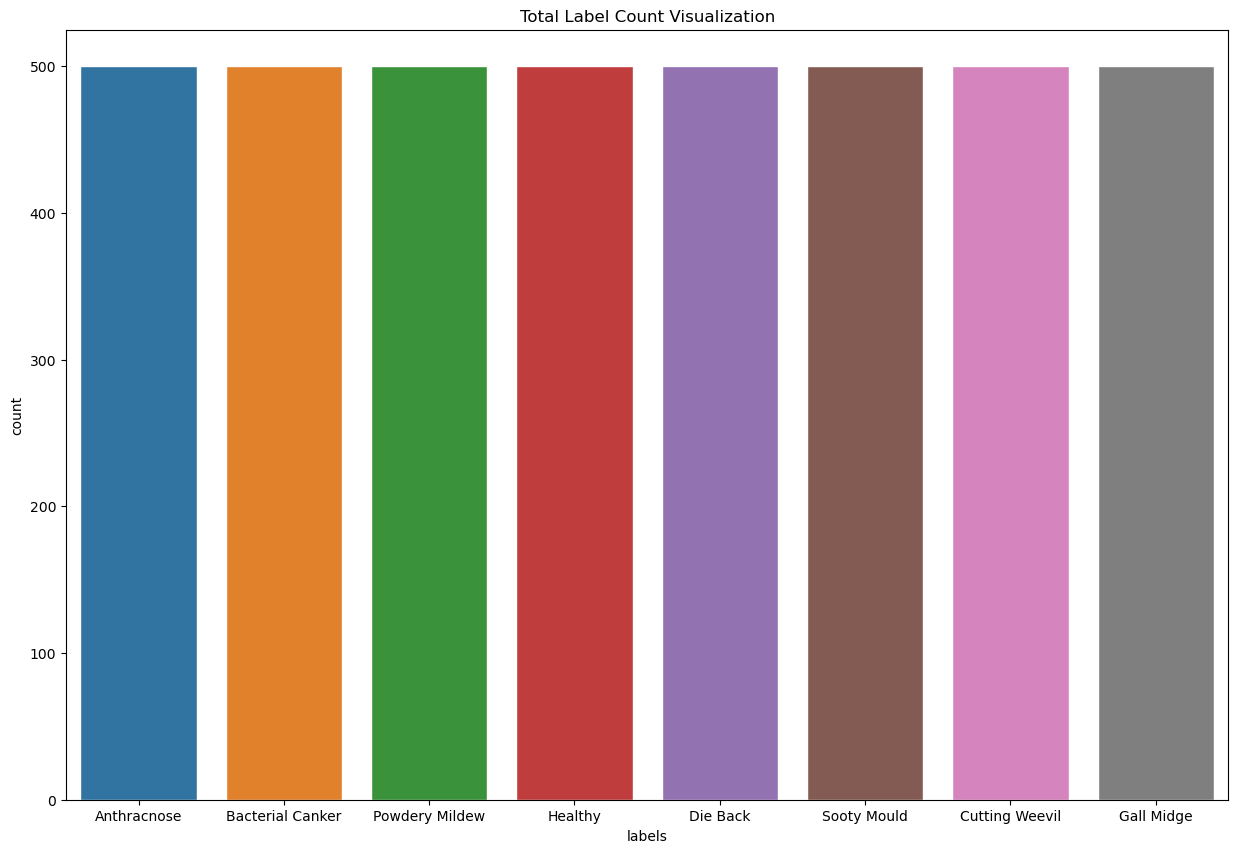

In [8]:
plt.figure(figsize = (15,10)) # Label Count
plt.title('Total Label Count Visualization')
sns.set_style("white")
sns.countplot(x=data_df['labels'], data=data_df)

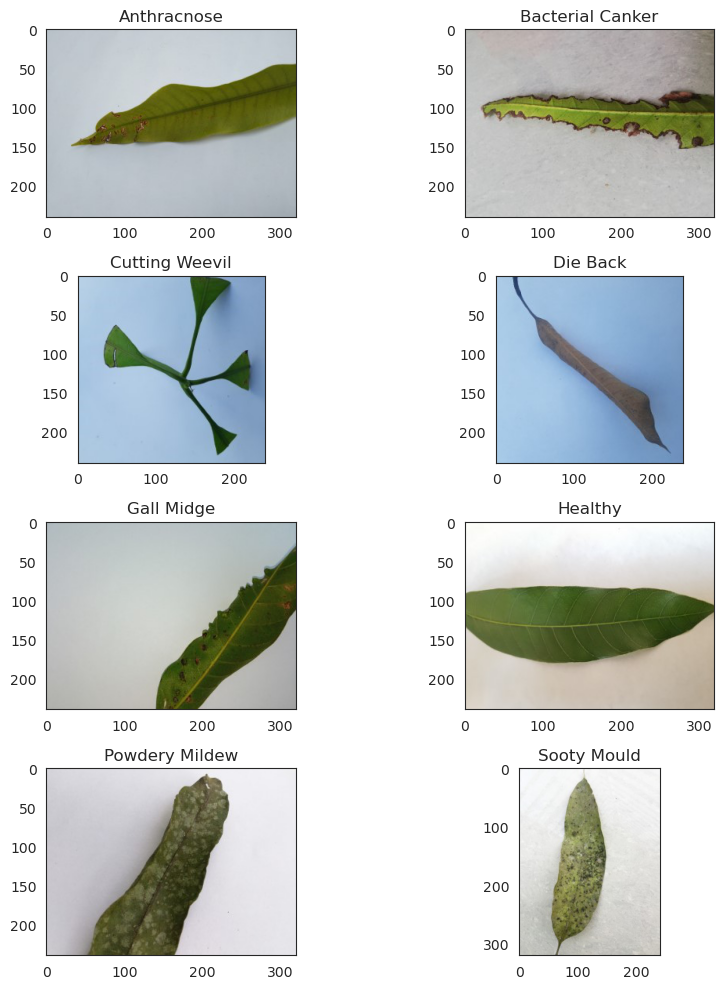

In [9]:
f, ax = plt.subplots(4,2) 
f.set_size_inches(10, 10)
k = 0
for i in range(4):
    for j in range(2):
        ax[i,j].set_title(data_df['labels'][k])
        img=plt.imread(data_df['filepaths'][k])
        ax[i,j].imshow(img)
        k += 500
    plt.tight_layout() 

# Creating the data generator using ImageDataGenerator for the CNN

In [10]:
def train_val_generators():
    """
    Creates the training and validation data generators
  
    Returns:
        train_generator, validation_generator - tuple containing the generators 
    """
    
    # Instantiate the ImageDataGenerator class ,normalize pixel values and set arguments to augment the images 
    datagen = ImageDataGenerator(rescale=1.0/255.0,
                                       rotation_range=80,
                                       width_shift_range=0.1,
                                       height_shift_range=0.1,
                                       shear_range=0.1,
                                       zoom_range=0.1,
                                       horizontal_flip = True,
                                       vertical_flip = True,
                                       fill_mode='nearest',
                                       validation_split=0.2)
    # Pass in the appropriate arguments to the flow method
    train_generator = datagen.flow_from_dataframe(dataframe=data_df,
                                                        x_col="filepaths",
                                                        y_col="labels",
                                                        subset="training",
                                                        batch_size=64,
                                                        seed=42,
                                                        shuffle=True,
                                                        class_mode="categorical",
                                                        target_size=(150,150))
    
    # Pass in the appropriate arguments to the flow method
    validation_generator = datagen.flow_from_dataframe(dataframe=data_df,
                                                        x_col="filepaths",
                                                        y_col="labels",
                                                        subset="validation",
                                                        batch_size=16,
                                                        shuffle=False,
                                                        class_mode="categorical",
                                                        target_size=(150,150))
    return train_generator, validation_generator

In [11]:
train_generator, validation_generator = train_val_generators()

Found 3200 validated image filenames belonging to 8 classes.
Found 800 validated image filenames belonging to 8 classes.


# Define and compile the model

In [27]:
pre_trained_model = tf.keras.applications.vgg16.VGG16(input_shape = (150, 150, 3), 
                                include_top = False, 
                                weights = 'imagenet')
for layer in pre_trained_model.layers:
    layer.trainable = False

58889256/58889256 [==============================] - 2s 0us/step


In [28]:
pre_trained_model.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [29]:
# Choose `block5_pool` as the last layer of your base model
last_layer = pre_trained_model.get_layer('block5_pool')
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

last layer output shape:  (None, 4, 4, 512)


In [32]:
from tensorflow.keras import layers, Model

# Flatten the output layer to 1 dimension
x = layers.Flatten()(last_output)
# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)
# Add a dropout rate of 0.2
x = layers.Dropout(0.2)(x)                  
# Add a final sigmoid layer for classification
x = layers.Dense  (class_count, activation='softmax')(x)           

# Append the dense network to the base model
model = Model(pre_trained_model.input, x) 

# Print the model summary. See your dense network connected at the end.
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 150, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 150, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 150, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 75, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 75, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 75, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 37, 128)       0     

In [33]:
model.compile(optimizer='adam',
                loss='categorical_crossentropy',
                metrics=['accuracy'])

# Creating a Callback class

In [34]:
class myCallback(tf.keras.callbacks.Callback):
    # Define the correct function signature for on_epoch_end
    def on_epoch_end(self, epoch, logs={}):
        if (logs.get('val_accuracy') is not None and logs.get('val_accuracy') > 0.95): 
            print(logs.get('val_accuracy'))
            print("\nReached 95% validation accuracy so cancelling training!")
callbacks = myCallback() 

In [15]:
reduce_lr = ReduceLROnPlateau(
    monitor='val_loss', 
    factor=0.25,   
    patience=2, 
    min_lr=1e-6,
    verbose=2
)

# Train the model

In [35]:
# Train the model
history = model.fit(train_generator,
                    epochs=5,
                    validation_data =validation_generator, 
                    callbacks=[callbacks]
                   )

Epoch 1/5
50/50 [==============================] - 330s 7s/step - loss: 1.0507 - accuracy: 0.6600 - val_loss: 0.4313 - val_accuracy: 0.8512
Epoch 2/5
50/50 [==============================] - 329s 7s/step - loss: 0.3769 - accuracy: 0.8687 - val_loss: 0.2823 - val_accuracy: 0.9162
Epoch 3/5
50/50 [==============================] - 328s 7s/step - loss: 0.2935 - accuracy: 0.8966 - val_loss: 0.2406 - val_accuracy: 0.9325
Epoch 4/5
50/50 [==============================] - 329s 7s/step - loss: 0.2464 - accuracy: 0.9131 - val_loss: 0.1962 - val_accuracy: 0.9337
Epoch 5/5
50/50 [==============================] - 330s 7s/step - loss: 0.1989 - accuracy: 0.9278 - val_loss: 0.1765 - val_accuracy: 0.9463


#  Evaluating Accuracy and Loss for the Model

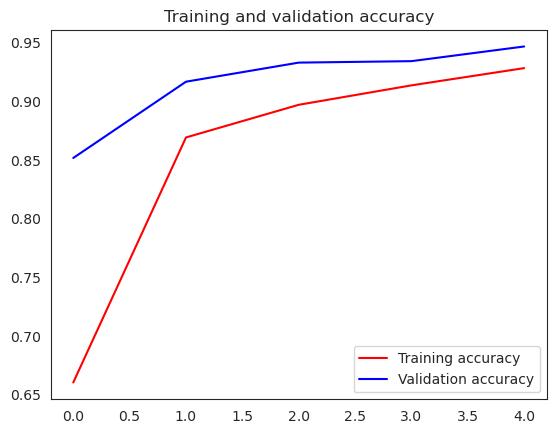

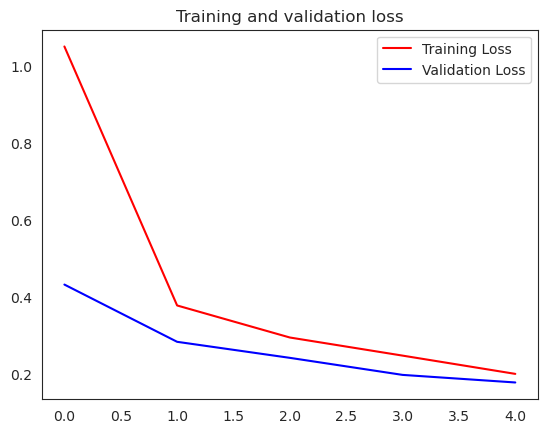

In [36]:
# Plot the chart for accuracy and loss on both training and validation
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training Loss')
plt.plot(epochs, val_loss, 'b', label='Validation Loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [37]:
print("Accuracy of the model is - " , model.evaluate(validation_generator)[1]*100 , "%")

50/50 [==============================] - 65s 1s/step - loss: 0.1733 - accuracy: 0.9425
Accuracy of the model is -  94.24999952316284 %


In [38]:
predictions = model.predict(validation_generator)
predictions=np.argmax(predictions,axis=-1)
predictions[:10]

50/50 [==============================] - 66s 1s/step


array([0, 1, 6, 5, 5, 7, 3, 3, 7, 7])

#  Evaluating  Precision, Recall, F1-Score and Support for the Model

In [39]:
dict_cls = validation_generator.class_indices

In [40]:
print(dict_cls)

{'Anthracnose': 0, 'Bacterial Canker': 1, 'Cutting Weevil': 2, 'Die Back': 3, 'Gall Midge': 4, 'Healthy': 5, 'Powdery Mildew': 6, 'Sooty Mould': 7}


In [41]:
print(classification_report(validation_generator.labels, predictions, target_names = list(dict_cls.keys())))

                  precision    recall  f1-score   support

     Anthracnose       0.84      0.98      0.90        84
Bacterial Canker       1.00      0.87      0.93       103
  Cutting Weevil       1.00      1.00      1.00       100
        Die Back       1.00      0.96      0.98       111
      Gall Midge       0.91      0.98      0.94        94
         Healthy       0.88      0.96      0.92       100
  Powdery Mildew       0.91      0.90      0.91       104
     Sooty Mould       0.95      0.84      0.89       104

        accuracy                           0.94       800
       macro avg       0.94      0.94      0.93       800
    weighted avg       0.94      0.94      0.94       800



# Plotting the Confusion Matrix for the Classification

<AxesSubplot:>

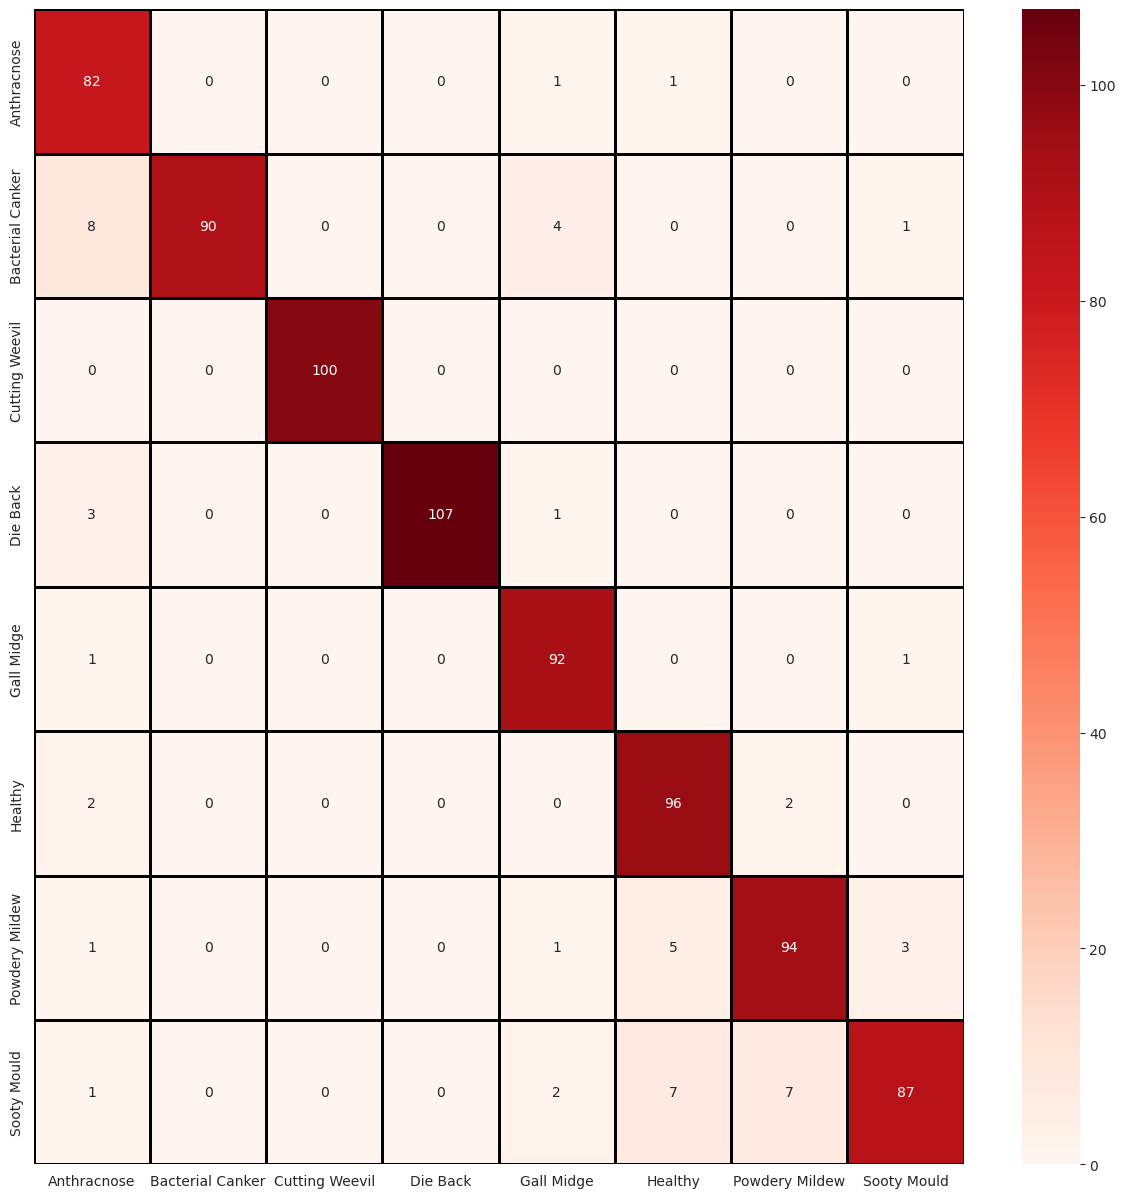

In [42]:
cm = confusion_matrix(validation_generator.labels,predictions)
cm = pd.DataFrame(cm , index = list(dict_cls.keys()) , columns = list(dict_cls.keys()))
plt.figure(figsize = (15,15))
sns.heatmap(cm,cmap= "Reds", linecolor = 'black' , linewidth = 1 , annot = True, fmt='')

In [43]:
def class_name(id):
    key_list = list(dict_cls.keys())
    val_list = list(dict_cls.values())
    position = val_list.index(id)
    return key_list[position]

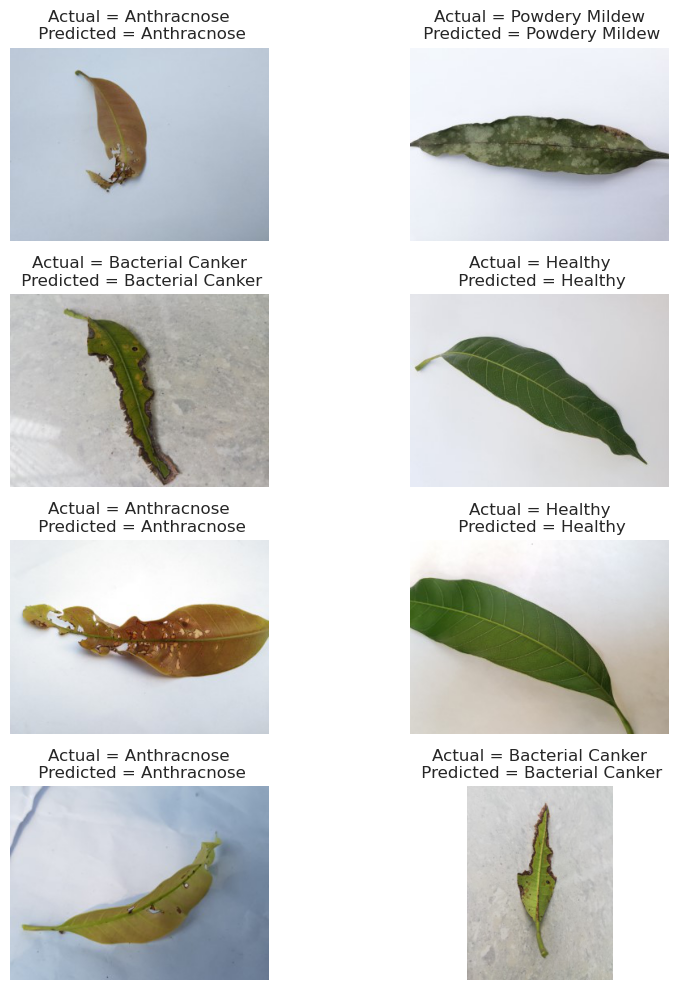

In [44]:
f, ax = plt.subplots(4,2) 
f.set_size_inches(10, 10)
k = 0
for i in range(4):
    for j in range(2):
        true_cls = validation_generator.labels[k]
        true_cls = class_name(true_cls)
        pred_cls = predictions[k]
        pred_cls = class_name(pred_cls)
        ax[i,j].set_title(f'Actual = {true_cls}\n Predicted = {pred_cls}')
        img=plt.imread(validation_generator.filenames[k])
        ax[i,j].imshow(img)
        ax[i,j].axis('off')
        k += 50
    
    plt.tight_layout() 